# **Malicious URL Detection**

In [36]:
!pip install tld

## **Importing Libraries**

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse
from tld import get_tld
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

## **Load Dataset**

In [38]:
urldata = pd.read_csv('malicious_phish.csv')
urldata.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


## **Meta information of Dataframe**

In [39]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


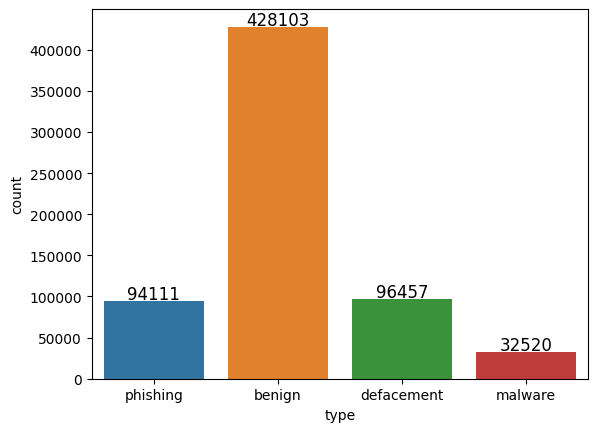

In [40]:
ax = sns.countplot(x='type', data=urldata, hue='type')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

## **Checking for NaN Values**

In [41]:
urldata.isna().sum()

url     0
type    0
dtype: int64

## **Feature Extraction**

In [42]:
urldata['url'] = urldata['url'].replace('www.', '', regex=True)

In [43]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}}
urldata['Category'] = urldata['type']
urldata = urldata.replace(rem)
urldata.head()

,url,type,Category
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [44]:
urldata['url_length'] = urldata['url'].apply(lambda i: len(str(i)))

In [45]:
urldata['hostname_length'] = urldata['url'].apply(lambda i: len(urlparse(i).netloc))

In [46]:
urldata['path_length'] = urldata['url'].apply(lambda i: len(urlparse(i).path))

In [47]:
def fd_length(url):
    urlpath = urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

urldata['fd_length'] = urldata['url'].apply(lambda i: fd_length(i))

In [48]:
urldata['tld'] = urldata['url'].apply(lambda i: get_tld(i, fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

urldata['tld_length'] = urldata['tld'].apply(lambda i: tld_length(i))

In [49]:
urldata.head()

,url,type,Category,url_length,hostname_length,path_length,fd_length,tld,tld_length
0,br-icloud.com.br,phishing,2,16,0,16,0,None,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,35,5,None,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,31,7,None,-1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,17,10,9,be,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23,10,9,net,3


In [50]:
urldata = urldata.drop("tld", axis=1)

In [51]:
urldata.head()

,url,type,Category,url_length,hostname_length,path_length,fd_length,tld_length
0,br-icloud.com.br,phishing,2,16,0,16,0,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,35,5,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,31,7,-1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,17,10,9,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23,10,9,3


In [52]:
feature = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//', '%', 'http', 'https']
for a in feature:
    urldata[a] = urldata['url'].apply(lambda i: i.count(a))

In [53]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
urldata['count-digits'] = urldata['url'].apply(lambda i: digit_count(i))

In [54]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
urldata['count-letters'] = urldata['url'].apply(lambda i: letter_count(i))

In [55]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
urldata['count_dir'] = urldata['url'].apply(lambda i: no_of_dir(i))

In [56]:
urldata.head()

,url,type,Category,url_length,hostname_length,path_length,fd_length,tld_length,@,?,...,$,!,*,",",//,http,https,count-digits,count-letters,count_dir
0,br-icloud.com.br,phishing,2,16,0,16,0,-1,0,0,...,0,0,0,0,0,0,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,35,5,-1,0,0,...,0,0,0,0,0,0,0,1,29,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,31,7,-1,0,0,...,0,0,0,0,0,0,0,1,25,3
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,17,10,9,2,0,1,...,0,0,0,0,1,1,0,7,60,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23,10,9,3,0,1,...,0,0,0,0,1,1,0,22,199,1


In [57]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}',
        url)  # Ipv6
    if match:
        return -1
    else:
        return 1
urldata['use_of_ip'] = urldata['url'].apply(lambda i: having_ip_address(i))

In [58]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return -1
    else:
        return 1
urldata['short_url'] = urldata['url'].apply(lambda i: shortening_service(i))

In [59]:
urldata.head()

,url,type,Category,url_length,hostname_length,path_length,fd_length,tld_length,@,?,...,*,",",//,http,https,count-digits,count-letters,count_dir,use_of_ip,short_url
0,br-icloud.com.br,phishing,2,16,0,16,0,-1,0,0,...,0,0,0,0,0,0,13,0,1,1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,35,5,-1,0,0,...,0,0,0,0,0,1,29,2,1,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,31,7,-1,0,0,...,0,0,0,0,0,1,25,3,1,1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,17,10,9,2,0,1,...,0,0,1,1,0,7,60,1,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23,10,9,3,0,1,...,0,0,1,1,0,22,199,1,1,1


##**Beautiful Visualizations**

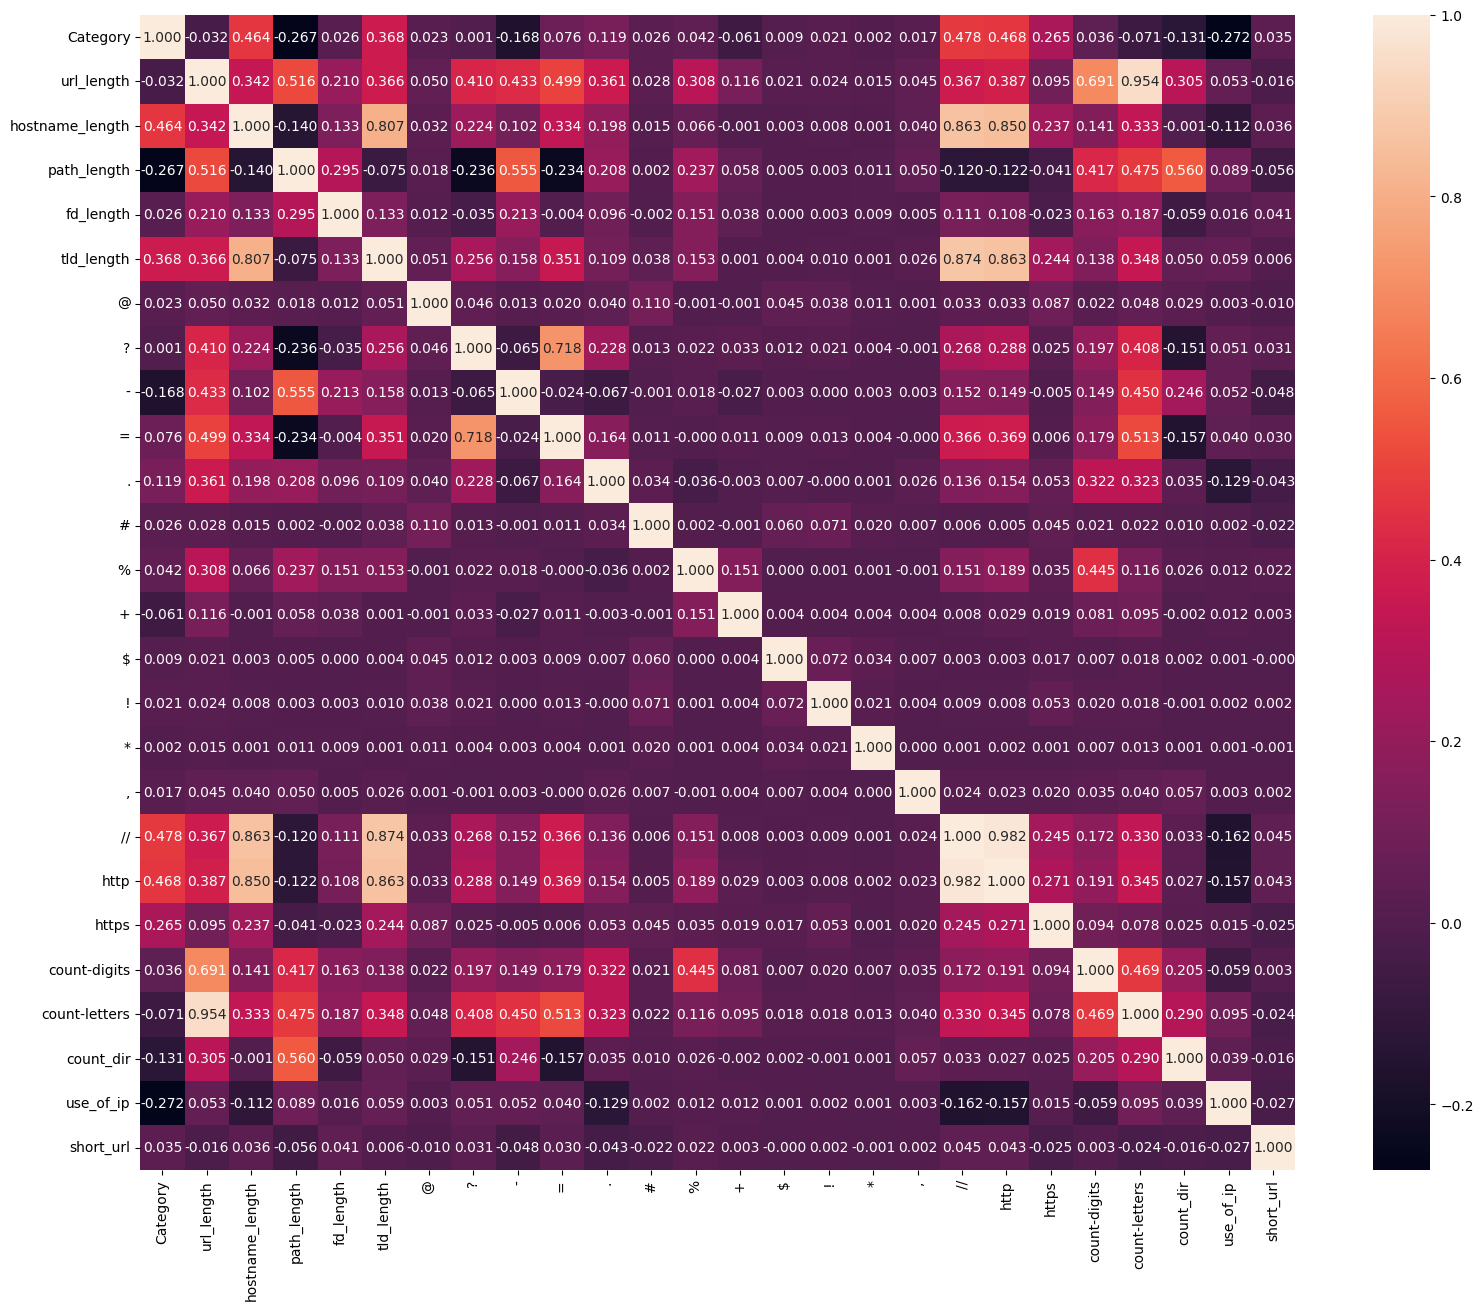

In [60]:
corrmat = urldata.iloc[:,2:].corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, square=True, annot=True, annot_kws={'size': 10}, fmt='.3f');

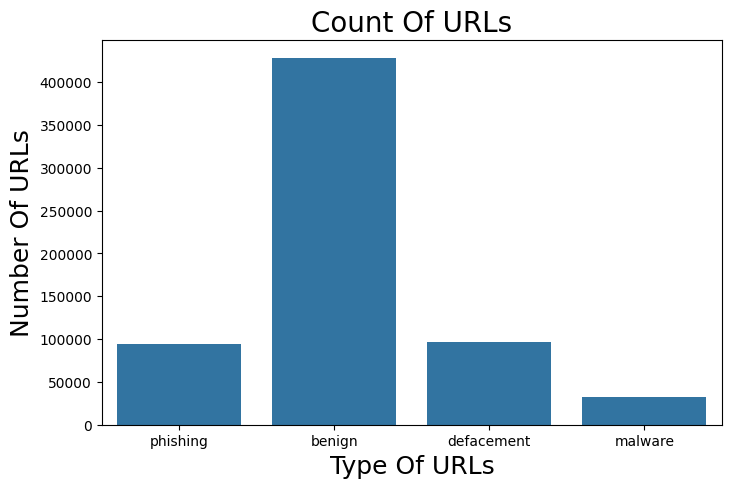

In [61]:
plt.figure(figsize=(8, 5))
sns.countplot(x='type', data=urldata)
plt.title("Count Of URLs", fontsize=20)
plt.xlabel("Type Of URLs", fontsize=18)
plt.ylabel("Number Of URLs", fontsize=18);

In [62]:
print("Percent Of Malicious URLs:{:.2f} %".format(len(urldata[urldata['type']=='malicious'])/len(urldata['type'])*100))
print("Percent Of Benign URLs:{:.2f} %".format(len(urldata[urldata['type']=='benign'])/len(urldata['type'])*100))

Percent Of Malicious URLs:0.00 %
Percent Of Benign URLs:65.74 %


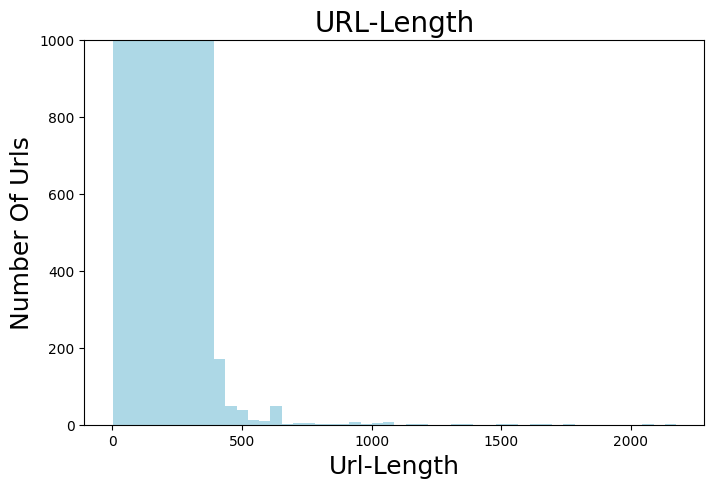

In [63]:
plt.figure(figsize=(8, 5))
plt.hist(urldata['url_length'], bins=50, color='LightBlue')
plt.title("URL-Length", fontsize=20)
plt.xlabel("Url-Length", fontsize=18)
plt.ylabel("Number Of Urls", fontsize=18)
plt.ylim(0, 1000);

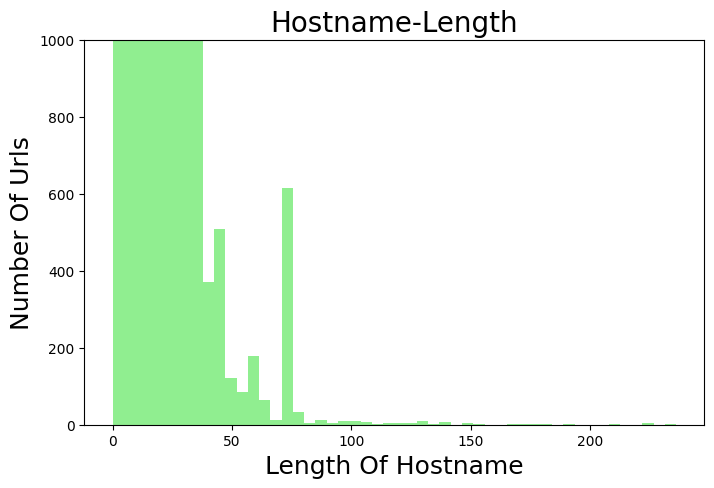

In [64]:
plt.figure(figsize=(8, 5))
plt.hist(urldata['hostname_length'], bins=50, color='Lightgreen')
plt.title("Hostname-Length", fontsize=20)
plt.xlabel("Length Of Hostname", fontsize=18)
plt.ylabel("Number Of Urls", fontsize=18)
plt.ylim(0, 1000);

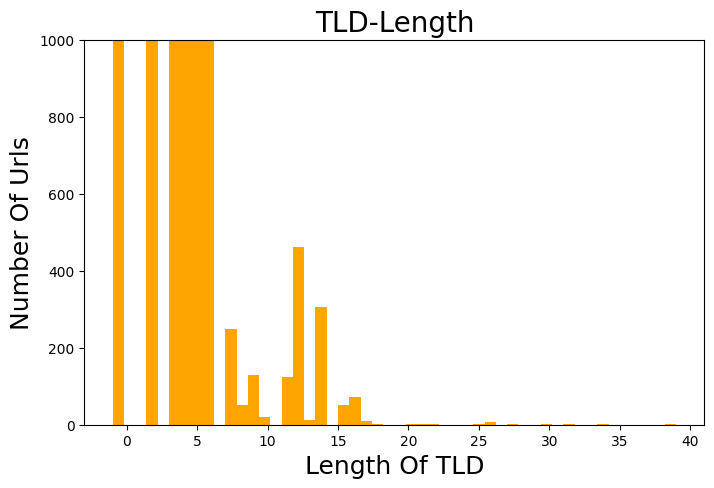

In [65]:
plt.figure(figsize=(8, 5))
plt.hist(urldata['tld_length'], bins=50, color='orange')
plt.title("TLD-Length", fontsize=20)
plt.xlabel("Length Of TLD", fontsize=18)
plt.ylabel("Number Of Urls", fontsize=18)
plt.ylim(0, 1000);

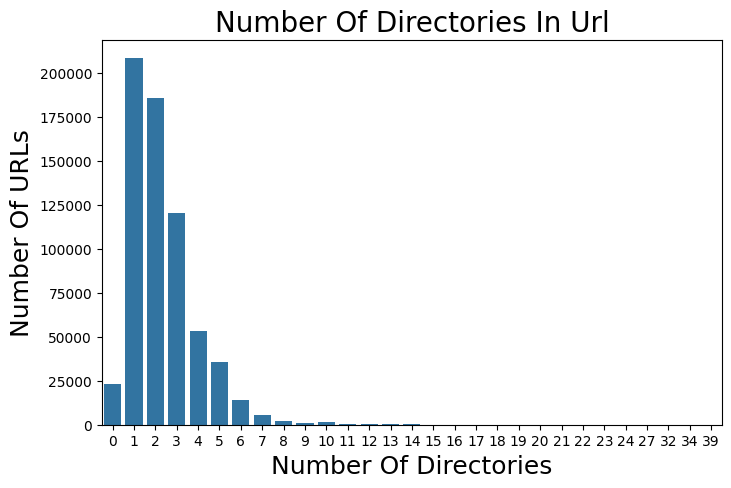

In [66]:
plt.figure(figsize=(8, 5))
plt.title("Number Of Directories In Url", fontsize=20)
sns.countplot(x='count_dir', data=urldata)
plt.xlabel("Number Of Directories", fontsize=18)
plt.ylabel("Number Of URLs", fontsize=18);

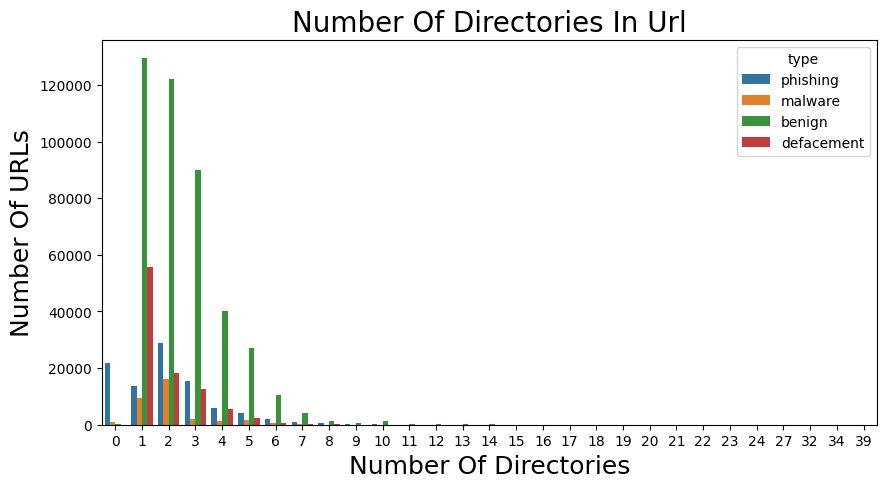

In [67]:
plt.figure(figsize=(10, 5))
plt.title("Number Of Directories In Url", fontsize=20)
sns.countplot(x='count_dir', data=urldata, hue='type')
plt.xlabel("Number Of Directories", fontsize=18)
plt.ylabel("Number Of URLs", fontsize=18);

## **Train & Test Split**

In [68]:
X = urldata.drop(['url', 'type', 'Category'], axis=1)
y = urldata['Category']
X.shape, y.shape

((651191, 25), (651191,))

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

## **Training Models**

_______________________________________________
Model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Test Accuracy :  92.71%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     85768
           1       0.98      0.98      0.98     19198
           2       0.78      0.71      0.74     18733
           3       0.95      0.94      0.94      6540

    accuracy                           0.93    130239
   macro avg       0.91      0.90      0.90    130239
weighted avg       0.92      0.93      0.93    130239

             Confusion_matrix 


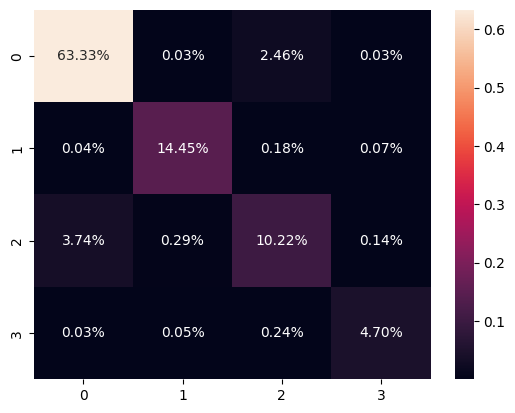

_______________________________________________
_______________________________________________
Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Test Accuracy :  93.75%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     85768
           1       0.98      0.99      0.99     19198
           2       0.83      0.72      0.77     18733
           3       0.99      0.93      0.96      6540

    accuracy                           0.94    130239
   macro avg       0.94      0.90      0.92    130239
weighted avg       0.94      0.94      0.94    130239

             Confusion_matrix 


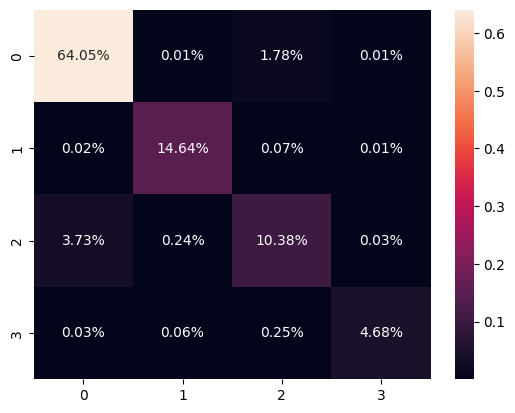

_______________________________________________
_______________________________________________
Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
Test Accuracy :  31.08%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.91      0.20      0.32     85768
           1       0.86      0.91      0.88     19198
           2       0.57      0.15      0.24     18733
           3       0.04      0.52      0.07      6540

    accuracy                           0.31    130239
   macro avg       0.59      0.44      0.38    130239
weighted avg       0.81      0.31      0.38    130239

             Confusion_matrix 


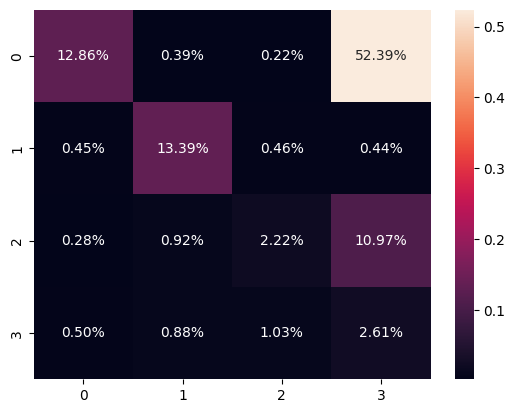

_______________________________________________
_______________________________________________
Model: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
Test Accuracy :  82.62%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.83      0.99      0.90     85768
           1       0.84      0.88      0.86     19198
           2       0.53      0.11      0.18     18733
           3       0.87      0.61      0.72      6540

    accuracy                           0.83    130239
   macro avg       0.77      0.64      0.66    130239
weighted avg       0.79      0.83      0.78    130239

             Confusion_matrix 


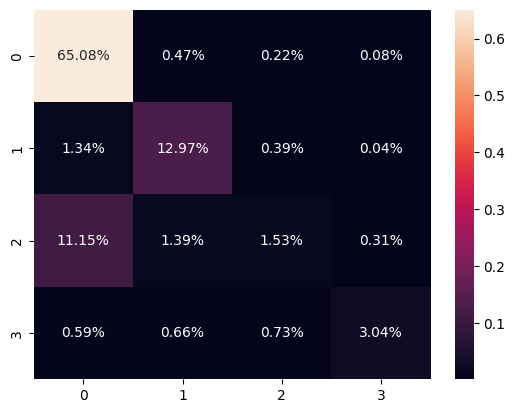

_______________________________________________
_______________________________________________
Model: <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>
Test Accuracy :  93.72%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     85768
           1       0.98      0.99      0.99     19198
           2       0.84      0.71      0.77     18733
           3       0.99      0.93      0.96      6540

    accuracy                           0.94    130239
   macro avg       0.94      0.90      0.92    130239
weighted avg       0.93      0.94      0.94    130239

             Confusion_matrix 


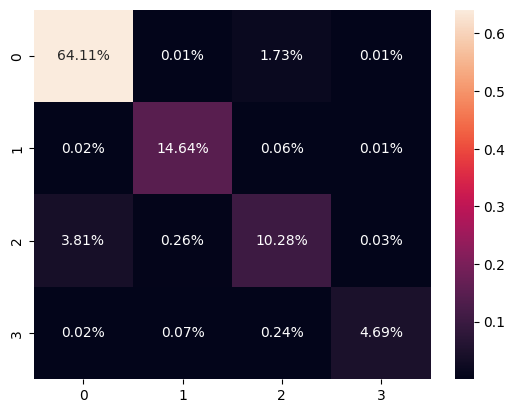

_______________________________________________
_______________________________________________
Model: <class 'sklearn.naive_bayes.GaussianNB'>
Test Accuracy :  78.52%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     85768
           1       0.65      0.99      0.79     19198
           2       0.68      0.04      0.08     18733
           3       0.53      0.54      0.54      6540

    accuracy                           0.79    130239
   macro avg       0.68      0.62      0.57    130239
weighted avg       0.78      0.79      0.73    130239

             Confusion_matrix 


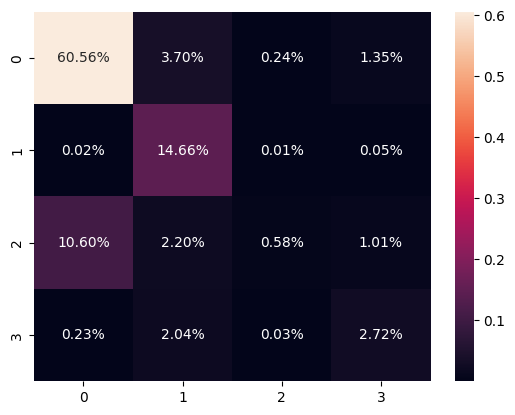

_______________________________________________


In [70]:
models = [DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, SGDClassifier, ExtraTreesClassifier, GaussianNB]
accuracy_test=[]
for m in models:
    print('_______________________________________________')
    print(f'Model: \033[1m{m}\033[0m')
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='0.2%')
    plt.show()
    print('\033[31m_______________________________________________\033[0m')

## **Final Report**

In [71]:
output = pd.DataFrame({
    "Model": ['Decision Tree Classifier', 'Random Forest Classifier', 'AdaBoost Classifier', 'SGD Classifier', 'Extra Trees Classifier', 'Gaussian NB'],
    "Accuracy": accuracy_test
    })
output

,Model,Accuracy
0,Decision Tree Classifier,0.927073
1,Random Forest Classifier,0.937469
2,AdaBoost Classifier,0.310844
3,SGD Classifier,0.826173
4,Extra Trees Classifier,0.937154
5,Gaussian NB,0.785210


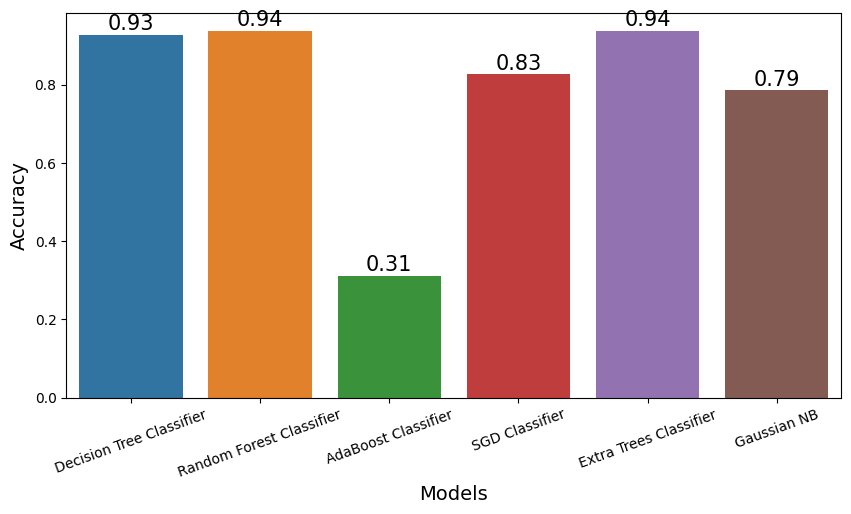

In [72]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output, hue='Model')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), (bar.get_x() + bar.get_width()/2, bar.get_height()), ha='center', va='center', size=15,
                   xytext=(0, 8), textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

In [73]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [74]:
import joblib
joblib.dump(rf_model,'random_forest_model.pkl')

['random_forest_model.pkl']